In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('yacht')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30], learning_rate = 0.001)

initial loss:  1.267212986946106
final loss:  -5.590872764587402
initial loss:  1.0623314380645752
final loss:  -6.175308704376221
initial loss:  1.0705493688583374
final loss:  -5.813064098358154
initial loss:  1.133994698524475
final loss:  -5.846932888031006
initial loss:  1.0862255096435547
final loss:  -5.712303638458252


Deep ensemble test MAPE:  0.33806634
Deep ensemble test RMSE:  1.3510973


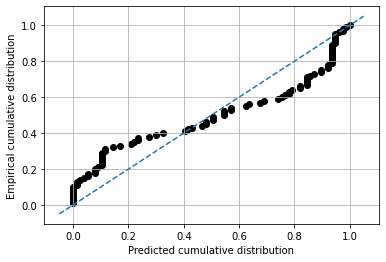

Deep ensemble test calibration error when step size is 0.001:  11.935338758643951
Deep ensemble test calibration error when step size is 0.01:  1.2140386237139482
Deep ensemble test calibration error when step size is 0.1:  0.13099173553719007


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

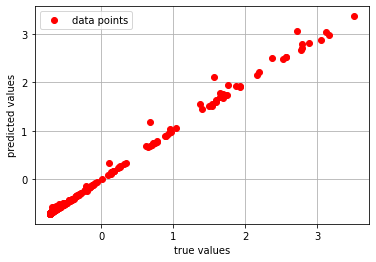

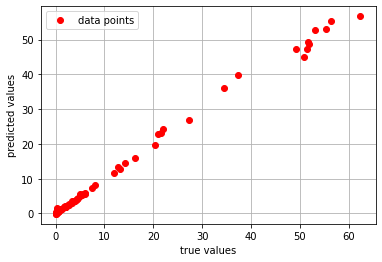

In [6]:
plt.plot(y_train.detach().numpy(), deep_ensemble_model(x_train)[0].detach().numpy().squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

plt.plot(y_test.detach().numpy(), mean_pred.squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

In [7]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 500, n_features = 100, learning_rate = 0.001)

final loss:  -4.873736381530762


Concrete dropout test MAPE:  1.0645111
Concrete dropout test RMSE:  3.689691


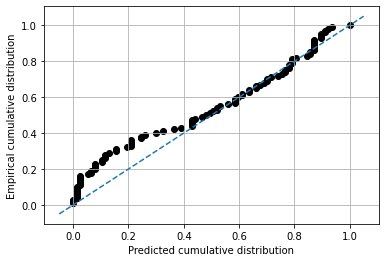

Concrete dropout test calibration error when step size is 0.001:  6.054980856805534
Concrete dropout test calibration error when step size is 0.01:  0.5983226513745996
Concrete dropout test calibration error when step size is 0.1:  0.054857480182155534


In [8]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy()) * torch.pow(y_sd, 2).detach().numpy()

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

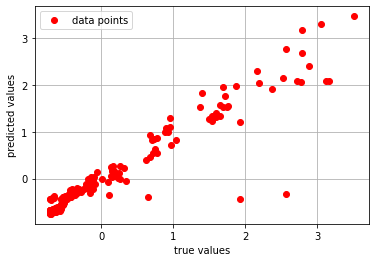

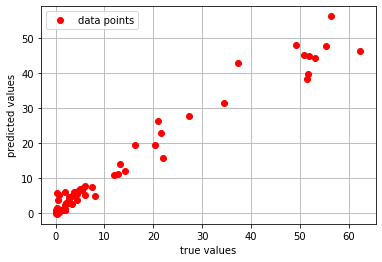

In [9]:
plt.plot(y_train.detach().numpy(), concrete_dropout_model(x_train)[0].detach().numpy().squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

plt.plot(y_test.detach().numpy(), mean_pred.squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()